In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

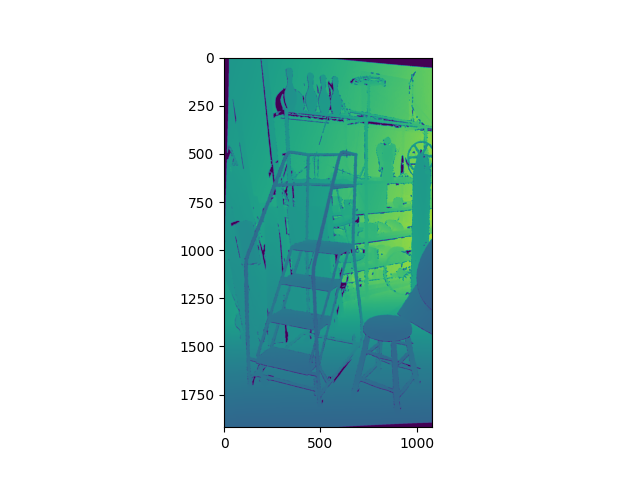

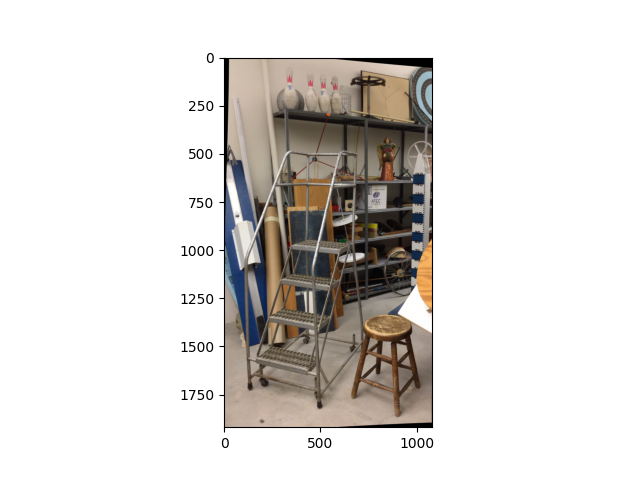

In [3]:
img_path = "~/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "~/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()

im = iio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm)

plt.figure()
plt.imshow(im)


In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [5]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, point_size=1,eye_dome_lighting=True)

In [6]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("QT5Agg")
cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(cps)

[[    897.94    1757.42     897.94    1757.42]
 [    887.55    1476.90     892.75    1466.51]
 [    186.25    1591.19     181.06    1580.80]
 [    342.10      79.50     342.10     100.28]]


In [7]:
#cps[:,2:] = cps[:,:2]

In [8]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

#cps = np.array([[    702.29,    1677.00   ,  704.87  ,  1679.58],
# [    898.67  ,  1757.10   ,  898.67 ,   1754.52],
# [   1002.03,    1674.41 ,    994.27  ,  1664.08],
# [    968.43 ,   1540.05,     968.43  ,  1545.22],
# [    890.92 ,   1586.56,     885.75   , 1583.97],
# [    735.88 ,   1532.30   ,  738.46   , 1534.88],
# [    141.57 ,    863.05   ,  138.99  ,   870.81]])

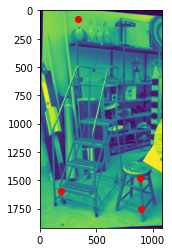

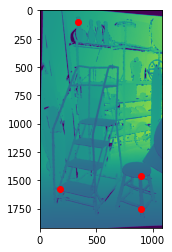

In [9]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dm,origin="upper")
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [10]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = cam @ ext

world_pts = dm_to_world(dm, cam, P,cps[:,2:])
world_pts

array([[    282.56,    2889.36,    6262.52],
       [    262.71,    1830.95,    6236.75],
       [  -2526.72,    2465.74,    6858.91],
       [  -2586.51,   -4642.45,    9388.54]], dtype=float32)

In [11]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [12]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      1.00      -0.03      -0.08     578.11]
 [      0.03       1.00       0.01     -23.80]
 [      0.08      -0.02       1.00     350.61]]
scale factor 0.999999997320275
A
[[      0.60       0.71      -0.37     372.68]
 [      0.32       0.21       0.92     106.95]
 [      0.73      -0.67      -0.10     324.16]
 [      0.00       0.00       0.00       1.00]]


In [13]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([    578.11,     -23.80,     350.61])

dmcp works with arbitrary transformation 

In [25]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

reproject points

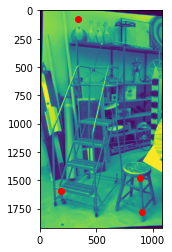

In [15]:
#P_trans @ world_pts
reprojected = P_trans @ np.hstack((world_pts,np.ones((world_pts.shape[0],1)))).T
reprojected = reprojected.T
repr0 = reprojected[:,0] / reprojected[:,-1]
repr1 = reprojected[:,1] / reprojected[:,-1]
repr = np.vstack((repr0,repr1)).T

plt.imshow(im[:,:,0])
plt.scatter(repr[:,0],repr[:,1], c="r")

#### test the same for custom depth map

In [35]:
from src.dmcpworkflow.capture_depth import generate_depth_map
import pyrender
pmesh = pyrender.Mesh.from_points(mesh.points, mesh["colors"])
tup = generate_depth_map(pmesh,cam,znear=10,zfar=1000000000)

[[      0.99      -0.11       0.12   -2930.61]
 [      0.10       0.99       0.10    1949.32]
 [     -0.13      -0.09       0.99   -8070.56]]
[[      0.99       0.11      -0.12]
 [      0.10      -0.99      -0.10]
 [     -0.13       0.09      -0.99]]
[[  -2930.61]
 [   1949.32]
 [  -8070.56]]


[[   1733.68       0.00     819.72]
 [      0.00    1733.68     957.55]
 [      0.00       0.00       1.00]]


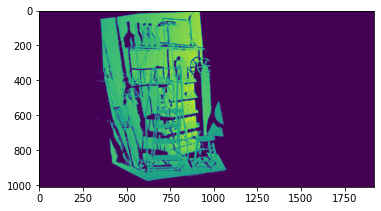

In [36]:
_dm, _dmK, _dmP = tup

print(_dmK)

plt.imshow(_dm)
plt.show()

In [44]:
from src.dmcpworkflow.annotate_points import annotate
mpl.use("QT5Agg")
_cps = annotate(im[:,:,0],_dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(_cps)

[[    186.30    1572.84     647.24     857.08]
 [    256.94    1363.54     667.89     759.01]
 [    317.11    1167.31     678.21     668.69]
 [    900.55    1750.75     990.47     864.82]
 [   1026.13     536.78     946.60     335.79]
 [    338.04      89.40     556.92      95.79]]


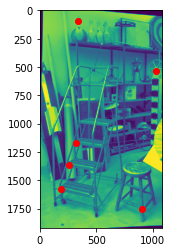

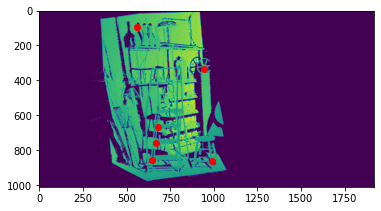

In [45]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(_cps[:,0],_cps[:,1],c="r")

plt.figure()
plt.imshow(_dm,origin="upper")
plt.scatter(_cps[:,2],_cps[:,3],c="r")

plt.show()

In [46]:
_world_pts = dm_to_world(_dm, _dmK, _dmP,_cps[:,2:])
_world_pts

array([[  -2572.29,    2491.15,    6878.91],
       [  -2298.11,    1673.79,    7082.17],
       [  -2111.27,     893.22,    7365.91],
       [    271.32,    2833.28,    6260.24],
       [   1135.56,   -2405.28,    9972.91],
       [  -2576.58,   -4734.44,    9366.20]], dtype=float32)

In [47]:
cps_mesh = pv.PolyData(_world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [48]:
_A = dmcp(_dmK, P_im, _cps[:,:2],_world_pts)
print(f"A\n{_A}")

estimated pose
[[      1.00      -0.01      -0.02     176.83]
 [      0.01       1.00      -0.03     249.28]
 [      0.03       0.03       1.00     164.86]]
scale factor 0.999999997320275
A
[[      0.65       0.67      -0.36     -27.63]
 [      0.28       0.23       0.93     383.90]
 [      0.71      -0.70      -0.04     156.11]
 [      0.00       0.00       0.00       1.00]]


In [49]:
_P_trans = P_im @ la.inv(_A)

print("pose (mm)")
_pos_est = la.null_space(_P_trans) / la.null_space(_P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

_pos_est = _pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
_pos_est 

pose (mm)


array([    176.83,     249.29,     164.86])

In [50]:
sv_est = pv.Sphere(center=_pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()